In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path
import pickle
import itertools
from scipy.stats import norm

import qng
import obnetwork2
import mmfitting
from mmfitting import crossval_summarize_mm

In [3]:
%matplotlib inline

## Data reading and prep

In [4]:
obsim_mm_means_df = pd.read_csv('../analysis_exp9_tandem05_nodischadj/mmdata/obsim_mm_means_df.csv', index_col=0)

Create lists of columns for subsetting the main dataframe using only relevant modeling columns for each unit. Then use these lists to create the various X dataframes.

In [5]:
# Define which columns are in which matrices starting with no queueing vars
X_pp_noq_cols = ['lam_obs', 'alos_pp', 'alos_pp_noc', 'alos_pp_c',
                 'tot_c_rate', 'cap_pp']

X_ldr_noq_cols = ['lam_obs', 'alos_obs', 'alos_ldr', 'cap_ldr',
                  'alos_pp', 'alos_pp_noc', 'alos_pp_c',
                  'tot_c_rate', 'cap_pp']

X_obs_noq_cols = ['lam_obs', 'alos_obs', 'cap_obs', 'alos_ldr', 'cap_ldr',
                  'alos_pp', 'alos_pp_noc', 'alos_pp_c',
                  'tot_c_rate', 'cap_pp']

# For "basicq" matrices, only load and rho variables are added
X_pp_basicq_cols = X_pp_noq_cols.copy()
X_pp_basicq_cols.extend(['load_pp', 'rho_pp'])

X_ldr_basicq_cols = X_ldr_noq_cols.copy()
X_ldr_basicq_cols.extend(['load_ldr', 'rho_ldr', 'load_pp', 'rho_pp'])

X_obs_basicq_cols = X_obs_noq_cols.copy()
X_obs_basicq_cols.extend(['load_obs', 'rho_obs', 'load_ldr',
                          'rho_ldr', 'load_pp', 'rho_pp'])

# For "q" matrices, include additional queueing approximations (not applicable
# to PP since unaffected by upstream unit and has no downstream unit

# LDR can have LOS shortened by patients blocked in OBS and have LOS lengthened
# by patients blocked in LDR by PP
X_ldr_q_cols = X_ldr_basicq_cols.copy()
X_ldr_q_cols.extend(['prob_blockedby_pp_approx', 'condmeantime_blockedbypp_approx',
                     'prob_blockedby_ldr_approx', 'condmeantime_blockedbyldr_approx',
                     'ldr_effmean_svctime_approx'])

# OBS modeled as infinite capacity system but time in system impacted by
# congestion in the downstream units.
X_obs_q_cols = X_obs_basicq_cols.copy()
X_obs_q_cols.extend(['prob_blockedby_pp_approx', 'condmeantime_blockedbypp_approx',
                     'prob_blockedby_ldr_approx', 'condmeantime_blockedbyldr_approx',
                     'ldr_effmean_svctime_approx'])


# Create dataframes based on the column specs above
X_pp_noq = obsim_mm_means_df.loc[:, X_pp_noq_cols]
X_ldr_noq = obsim_mm_means_df.loc[:, X_ldr_noq_cols]
X_obs_noq = obsim_mm_means_df.loc[:, X_obs_noq_cols]

# PP
X_pp_basicq = obsim_mm_means_df.loc[:, X_pp_basicq_cols]
X_pp_basicq['sqrt_load_pp'] = X_pp_basicq['load_pp'] ** 0.5
X_pp_basicq_cols = X_pp_basicq.columns.tolist()

# LDR
X_ldr_basicq = obsim_mm_means_df.loc[:, X_ldr_basicq_cols]
X_ldr_basicq['sqrt_load_ldr'] = X_ldr_basicq['load_ldr'] ** 0.5
X_ldr_basicq['sqrt_load_pp'] = X_ldr_basicq['load_pp'] ** 0.5
X_ldr_basicq_cols = X_ldr_basicq.columns.tolist()

X_ldr_q = obsim_mm_means_df.loc[:, X_ldr_q_cols]
X_ldr_q['sqrt_load_ldr'] = X_ldr_q['load_ldr'] ** 0.5
X_ldr_q['sqrt_load_pp'] = X_ldr_q['load_pp'] ** 0.5
X_ldr_q_cols = X_ldr_q.columns.tolist()

# OBS
X_obs_basicq = obsim_mm_means_df.loc[:, X_obs_basicq_cols]
X_obs_basicq['sqrt_load_obs'] = X_obs_basicq['load_obs'] ** 0.5
X_obs_basicq['sqrt_load_ldr'] = X_obs_basicq['load_ldr'] ** 0.5
X_obs_basicq['sqrt_load_pp'] = X_obs_basicq['load_pp'] ** 0.5

X_obs_q = obsim_mm_means_df.loc[:, X_obs_q_cols]
X_obs_q['sqrt_load_obs'] = X_obs_q['load_obs'] ** 0.5
X_obs_q['sqrt_load_ldr'] = X_obs_q['load_ldr'] ** 0.5
X_obs_q['sqrt_load_pp'] = X_obs_q['load_pp'] ** 0.5

# y vectors
y_pp_occ_mean = obsim_mm_means_df.loc[:, 'occ_mean_mean_pp']
y_pp_occ_p95 = obsim_mm_means_df.loc[:, 'occ_mean_p95_pp']
y_ldr_occ_mean = obsim_mm_means_df.loc[:, 'occ_mean_mean_ldr']
y_ldr_occ_p95 = obsim_mm_means_df.loc[:, 'occ_mean_p95_ldr']
y_obs_occ_mean = obsim_mm_means_df.loc[:, 'occ_mean_mean_obs']
y_obs_occ_p95 = obsim_mm_means_df.loc[:, 'occ_mean_p95_obs']

y_mean_pct_blocked_by_pp = obsim_mm_means_df.loc[:, 'prob_blockedby_pp_sim']
y_mean_pct_blocked_by_ldr = obsim_mm_means_df.loc[:, 'prob_blockedby_ldr_sim']
y_condmeantime_blockedbyldr = obsim_mm_means_df.loc[:, 'condmeantime_blockedbyldr_sim']
y_condmeantime_blockedbypp = obsim_mm_means_df.loc[:, 'condmeantime_blockedbypp_sim']

In [6]:
pp_occ_mean_basicq_hgbr_results = \
    mmfitting.crossval_summarize_mm('pp_occ_mean_basicq_lm', 'pp', 'occ_mean', X_pp_basicq, y_pp_occ_mean, scale=False,
                          flavor='hgbr')

pp_occ_p95_basicq_hgbr_results = \
    mmfitting.crossval_summarize_mm('pp_occ_mean_basicq_lm', 'pp', 'occ_mean', X_pp_basicq, y_pp_occ_p95, scale=False,
                          flavor='hgbr')

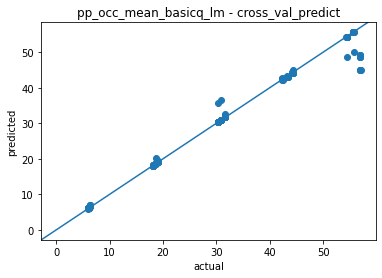

In [7]:
pp_occ_mean_basicq_hgbr_results['fitplot']

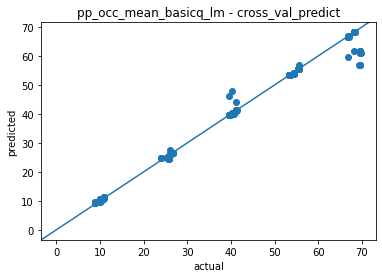

In [8]:
pp_occ_p95_basicq_hgbr_results['fitplot']

Let's try it on LDR

In [9]:
ldr_occ_mean_basicq_hgbr_results = \
    crossval_summarize_mm('ldr_occ_mean_basicq_nn', 'ldr', 'occ_mean', X_ldr_basicq, y_ldr_occ_mean, flavor='hgbr', scale=False)

ldr_occ_mean_q_hgbr_results = \
    crossval_summarize_mm('ldr_occ_mean_q_nn', 'ldr', 'occ_mean', X_ldr_q, y_ldr_occ_mean, flavor='hgbr', scale=False)

ldr_occ_mean_noq_hgbr_results = \
    crossval_summarize_mm('ldr_occ_mean_noq_nn', 'ldr', 'occ_mean', X_ldr_noq, y_ldr_occ_mean, flavor='hgbr', scale=False)

ldr_occ_p95_basicq_hgbr_results = \
    crossval_summarize_mm('ldr_occ_p95_basicq_nn', 'ldr', 'occ_p95', X_ldr_basicq, y_ldr_occ_p95, flavor='hgbr', scale=False)

ldr_occ_p95_q_hgbr_results = \
    crossval_summarize_mm('ldr_occ_p95_q_nn', 'ldr', 'occ_p95', X_ldr_q, y_ldr_occ_p95, flavor='hgbr', scale=False)

ldr_occ_p95_noq_hgbr_results = \
    crossval_summarize_mm('ldr_occ_p95_noq_nn', 'ldr', 'occ_p95', X_ldr_noq, y_ldr_occ_p95, flavor='hgbr', scale=False)

mean_pct_blocked_by_pp_basicq_hgbr_results = \
    crossval_summarize_mm('mean_pct_blocked_by_pp_q_nn', 'ldr', 'pct_blocked_by_pp', X_ldr_basicq, y_mean_pct_blocked_by_pp,
                                               scale=False, flavor='hgbr')

mean_pct_blocked_by_pp_q_hgbr_results = \
    crossval_summarize_mm('mean_pct_blocked_by_pp_basicq_nn', 'ldr', 'pct_blocked_by_pp', X_ldr_q, y_mean_pct_blocked_by_pp,
                                               scale=False, flavor='hgbr')

mean_pct_blocked_by_pp_noq_hgbr_results = \
    crossval_summarize_mm('mean_pct_blocked_by_pp_noq_nn', 'ldr', 'pct_blocked_by_pp', X_ldr_noq, y_mean_pct_blocked_by_pp,
                                               scale=False, flavor='hgbr')

condmeantime_blockedbypp_basicq_hgbr_results = \
    crossval_summarize_mm('condmeantime_blockedbypp_basicq', 'ldr', 'condmeantime_blockedbypp', X_ldr_basicq.iloc[:135], y_condmeantime_blockedbypp.iloc[:135],
                                               scale=False, flavor='hgbr')

condmeantime_blockedbypp_q_hgbr_results = \
    crossval_summarize_mm('condmeantime_blockedbypp_q', 'ldr', 'condmeantime_blockedbypp', X_ldr_q.iloc[:135], y_condmeantime_blockedbypp.iloc[:135],
                                               scale=False, flavor='hgbr')

condmeantime_blockedbypp_noq_hgbr_results = \
    crossval_summarize_mm('condmeantime_blockedbypp_noq', 'ldr', 'condmeantime_blockedbypp', X_ldr_noq.iloc[:135], y_condmeantime_blockedbypp.iloc[:135],
                                               scale=False, flavor='hgbr')

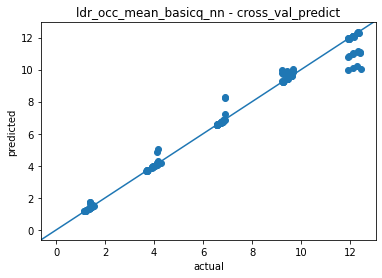

In [10]:
ldr_occ_mean_basicq_hgbr_results['fitplot']

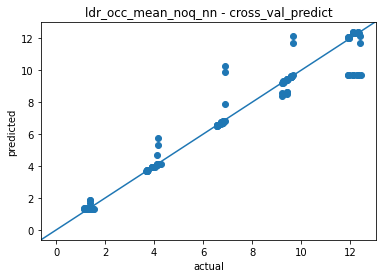

In [11]:
ldr_occ_mean_noq_hgbr_results['fitplot']

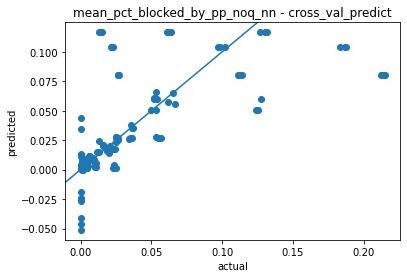

In [12]:
mean_pct_blocked_by_pp_noq_hgbr_results['fitplot']

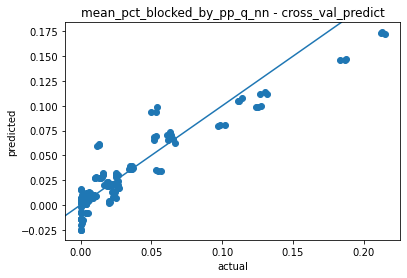

In [13]:
mean_pct_blocked_by_pp_basicq_hgbr_results['fitplot']

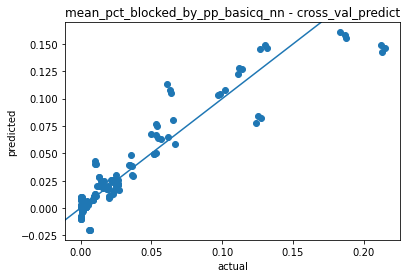

In [14]:
mean_pct_blocked_by_pp_q_hgbr_results['fitplot']